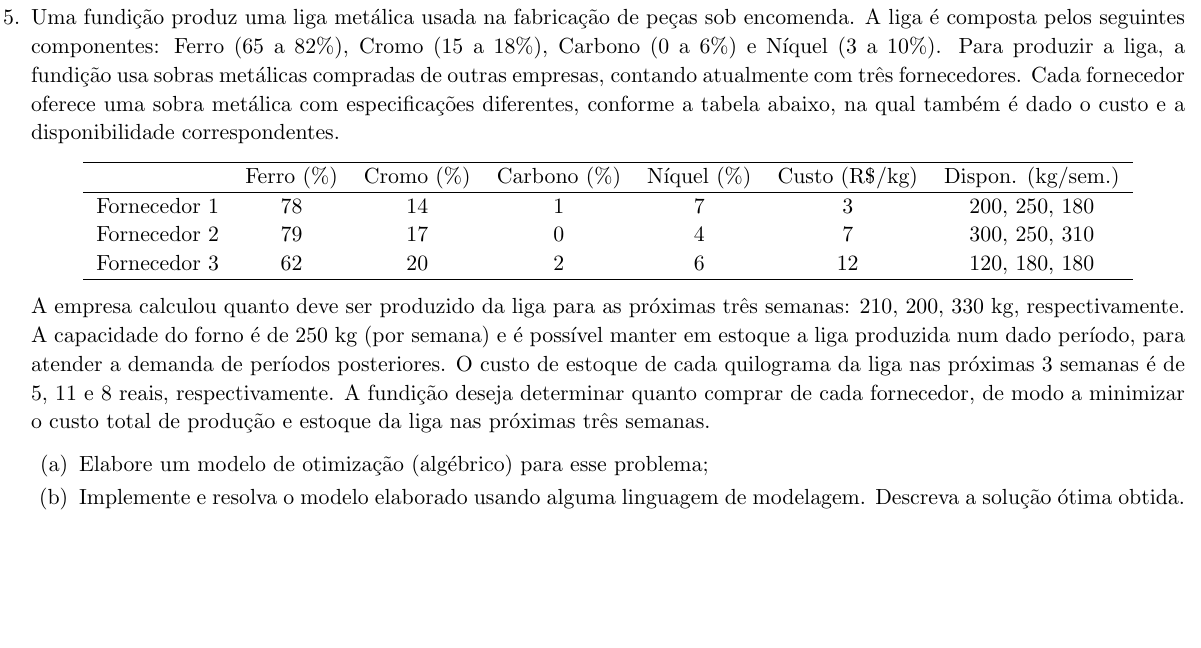

In [15]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename='images/5.png')

In [7]:
# Dados
Fornecedores = ['Fornecedor 1', 'Fornecedor 2', 'Fornecedor 3']
Materiais = ['Ferro', 'Cromo', 'Carbono', 'Níquel']
Semanas = [1, 2, 3]
min_composicao = {'Ferro': 0.65, 'Cromo': 0.15, 'Carbono': 0, 'Níquel': 0.03}
max_composicao = {'Ferro': 0.82, 'Cromo': 0.18, 'Carbono': 0.06, 'Níquel': 0.1}
composicao = {('Fornecedor 1', 'Ferro'): 0.78, ('Fornecedor 1', 'Cromo'): 0.14, ('Fornecedor 1', 'Carbono'): 0.01, ('Fornecedor 1', 
                                                                                                                    'Níquel'): 0.07,
              ('Fornecedor 2', 'Ferro'): 0.79, ('Fornecedor 2', 'Cromo'): 0.17, ('Fornecedor 2', 'Carbono'): 0, ('Fornecedor 2', 
                                                                                                                    'Níquel'): 0.04,
              ('Fornecedor 3', 'Ferro'): 0.62, ('Fornecedor 3', 'Cromo'): 0.2, ('Fornecedor 3', 'Carbono'): 0.02, ('Fornecedor 3', 
                                                                                                                    'Níquel'): 0.06}
custo_fornecedor = {'Fornecedor 1': 3, 'Fornecedor 2': 7, 'Fornecedor 3': 12}
disponibilidade = {('Fornecedor 1', 1): 200, ('Fornecedor 1', 2): 250, ('Fornecedor 1', 3): 180,
                   ('Fornecedor 2', 1): 300, ('Fornecedor 2', 2): 250, ('Fornecedor 2', 3): 310,
                   ('Fornecedor 3', 1): 120, ('Fornecedor 3', 2): 180, ('Fornecedor 3', 3): 180}
demanda = {1: 210, 2: 200, 3: 330}
custo_estoque = {1: 5, 2: 11, 3: 8}
capacidade = 250

In [8]:
# Módulos
from pyomo.environ import *
from pyomo.opt import SolverFactory

In [9]:
# Modelo
model = ConcreteModel()

# Conjuntos
model.F = Set(initialize=Fornecedores)
model.M = Set(initialize=Materiais)
model.T = Set(initialize=Semanas)

# Parâmetros
model.l = Param(model.M, initialize=min_composicao, within=NonNegativeReals)
model.u = Param(model.M, initialize=max_composicao, within=NonNegativeReals)
model.a = Param(model.F * model.M, initialize=composicao, within=NonNegativeReals)
model.c = Param(model.F, initialize=custo_fornecedor, within=NonNegativeReals)
model.e = Param(model.F * model.T, initialize=disponibilidade, within=NonNegativeReals)
model.d = Param(model.T, initialize=demanda, within=NonNegativeReals)
model.h = Param(model.T, initialize=custo_estoque, within=NonNegativeReals)

# Variáveis de decisão
model.x = Var(model.F * model.T, within=NonNegativeReals)
model.I = Var(model.T, within=NonNegativeReals)

# Função objetivo
model.obj = Objective(sense=minimize,
                     expr = (sum(sum(model.c[i] * model.x[i,t] for t in model.T) for i in model.F)) +
                             sum(model.h[t] * model.I[t] for t in model.T))

# Restrições
# 1 Entra = Sai
model.r_balanco = ConstraintList()
model.r_balanco.add(expr = sum(model.x[i,1] for i in model.F) == model.d[1] + model.I[1])
for t in [2, 3]:
    model.r_balanco.add(expr = model.I[t-1] + sum(model.x[i,t] for i in model.F) == model.d[t] + model.I[t])
# 2 Composição da liga (colocar tudo dependente de x em um lado da inequação)
model.r_composicao = ConstraintList()
for t in model.T:
    for j in model.M:
        model.r_composicao.add(expr = sum(model.a[i,j] * model.x[i,t] for i in model.F) - 
                               model.l[j] * sum(model.x[i,t] for i in model.F) >= 0)
        model.r_composicao.add(expr = sum(model.a[i,j] * model.x[i,t] for i in model.F) -
                               model.u[j] * sum(model.x[i,t] for i in model.F) <= 0)
# 3 Capacidade de produção
model.r_capacidade = ConstraintList()
for t in model.T:
    model.r_capacidade.add(expr = sum(model.x[i,t] for i in model.F) <= capacidade)
# 4 Disponibilidade de sobra metálica
model.r_disponibilidade = ConstraintList()
for i in model.F:
    for t in model.T:
        model.r_disponibilidade.add(expr = model.x[i,t] <= model.e[i,t])

# model.pprint()

In [10]:
# Resolução
solver = SolverFactory('glpk')
resultado = solver.solve(model, tee = False)

In [14]:
# Apresentação de resultados
if (resultado.solver.status == SolverStatus.ok) and (resultado.solver.termination_condition != TerminationCondition.infeasible):
    for t in model.T:
        for i in model.F:
            print('A quantidade comprada no período {} do {} foi {:.2f}'.format(t,i,value(model.x[i,t])))
        print('Foram estocados {:.2f}kg no período {}'.format(value(model.I[t]), t))
    print()
    print('O custo total mínimo atingido por essa configuração é de R${:.2f}'.format(model.obj.expr()))
else:
    print(resultado.solver.termination_condition)

A quantidade comprada no período 1 do Fornecedor 1 foi 160.00
A quantidade comprada no período 1 do Fornecedor 2 foi 80.00
A quantidade comprada no período 1 do Fornecedor 3 foi 0.00
Foram estocados 30.00kg no período 1
A quantidade comprada no período 2 do Fornecedor 1 foi 166.67
A quantidade comprada no período 2 do Fornecedor 2 foi 83.33
A quantidade comprada no período 2 do Fornecedor 3 foi 0.00
Foram estocados 80.00kg no período 2
A quantidade comprada no período 3 do Fornecedor 1 foi 166.67
A quantidade comprada no período 3 do Fornecedor 2 foi 83.33
A quantidade comprada no período 3 do Fornecedor 3 foi 0.00
Foram estocados 0.00kg no período 3

O custo total mínimo atingido por essa configuração é de R$4236.67
